# Graph Node Spectral Embedding

Embedding is an import machine learning concept. Embeddings use some form of context to map discrete or categorical variables into real-number vector representations. See https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526 for a brief background on embeddings.

The increasing interest in Graph Neural Networks raises the interesting question of how to create an embedding within the context of connections and relationships. Ideally, graph node embedding space similiarity (e.g. cosine similarity) reflects graph node similarity within the context of graph connections.

One application of graph node embedding is to create representations that are suitable for clustering, i.e. graph nodes that are similar w.r.t. their connections will be grouped together in the embedding space.

Spectral Embedding is one mechanism for creating graph node embeddings based on connections. Unlike other forms of embedding, spectral embeddings are **computed** as opposed to **learned**. The process is simple to implement, but involves some linear algebra. Fortunately, the complicated bits are easily handled with high performance library functions.

## Graphs, Vertices and Edges
Generally, a graph is defined as $G = (V,E)$ where $V$ is a set of vertices and $E$ is a set of edges representing connections between vertices. The terms *vertex* and *node* are used interchangably, as well as the terms *edge* and *arc*. There are myriad variations of graph types.

For simplicity, the graphs used in this notebook are limited to **simple graphs**, i.e. graphs where there can exist at most one, undirected and un-labeled edge between any two verticies. Additionally, node labels will consist of the integers \[0 .. N-1\] where N is the number of nodes in the graph.


## Spectral Embedding Outline

The following outline gives the steps for creating spectral embeddings for graph nodes. It represents an implementation modeled from an excellent presentation given by Tselil Schramm (Simons Institute) in 2017 (https://www.youtube.com/watch?v=-Afa1WI3iug) in the context of Graph Clustering Algorithms. Details for each step of the algorithm are given in connection with the Python code implementation.

1. Create an adjacency matrix representation of the graph
2. Compute the Laplacian representation from the adjacency matrix
3. Compute the Eigen System (Eigenvalues and Eigenvectors) of the Laplacian
4. Create the k-dimension embeddings map as a subset of the Eigenvectors

For an N-node graph with k-dimension embeddings, the embeddings map is an Nxk matrix consisting of a k-subset of the Eigenvectors forming the columns. The k-dimension embedding for the j<sup>th</sup> graph node is imply the j<sup>th</sup> row of the map.


## Step 1 - Create the Graph Adacency Matrix

A graph adjacency matrix, $A$, for an N-node graph is an NxN matrix where the rows and columns represent the graph nodes, and connections between nodes are marked with an entry of 1. For instance, if node $i$ is connected to node $j$, then a 1 will appear at $A[i,j]$.

A straightforward way to store a graph representation is as an edge list. In this file format, each line consists of two, space-separated labels representing an edge between two nodes in the graph, the first label being the edge source, the second the destination. The following function will read a simplified edge-list file (where node labels are a contiguous set of integers), and return the corresponding adjacency matrix.

In [1]:
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=4, floatmode='fixed')


In [2]:
def read_edge_list(filename):
    #
    #   read the graph edges as node label tuples
    #
    edges = []
    with open(filename, encoding='utf-8') as f:
        for line in f.readlines():
            n1,n2 = line[:-1].split(' ')
            edges.append((int(n1),int(n2)))    
    #
    #   create a set of node labels
    #
    nodes = set()
    for edge in edges:
        nodes.add(edge[0])
        nodes.add(edge[1])
    nodes = list(nodes)
    N = len(nodes)
    #
    #   we assume that graph node labels are a set of contiguous integers
    #
    assert max(nodes) == N - 1
    #
    #   create the adjacency matrix from the list of edge tuples
    #
    A = np.zeros((N,N), dtype='int')
    A[[edge[0] for edge in edges], [edge[1] for edge in edges]] = 1

    return A



As an example, here is a simple graph. Its edge-list is stored in graphs/simple-8-node-graph-edge-list.txt.

![](images/simple-8-node-graph.png)

In [3]:
A = read_edge_list('graphs/simple-8-node-graph-edge-list.txt')
print(A)

[[0 1 0 0 0 1 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 1]
 [1 0 0 0 0 0 1 0]
 [0 0 0 0 1 1 0 1]
 [0 0 0 1 1 0 1 0]]


A graph with undirected edges has a symmetric adjacency matrix, $A[i,j] = A[j,i]$. In addtion, if no graph node has a direct connection to itself (self-loop), the adjacency matrix diagonal will contain all zeros, $A[i,i] = 0$.

In [4]:
assert np.all(A == A.T) and np.all(np.diagonal(A) == 0) # test for simple graph

## Step 2 - Compute the Graph Laplacian from the Adjacency Matrix
The graph Laplacian matrix is another, equivalent representation of the graph node connections with a little added information. In the Laplacian representation, node connections are labeled with a -1 instead of a +1. In addition to the node-to-node connection information, the diagonal elements represent the node degrees, i.e. the number of connections each node has. For instance, in the graph shown above, the Laplacian graph matrix, $L$, will have a 2 in location $L[0,0]$ meaning that node $0$ has two connections to other nodes.

The Laplacian is computed from the adjacency matrix in two steps. First, the node degrees are computed. Then that result is combined with the adjacency matrix to form the Laplacian. To compute the node degrees, the marginal sum of the adjacency matrix is taken. It doesn't matter which axis is used for the sum since the matrix is symmteric. In the second step, the marginal sums are expanded into a diagonal matrix (zeros everywhere except along the diagonal) and the adjacency matrix is subtracted from it.
$$
L = D - A
$$
where $L$ is the Laplacian, $D$ is the diagnonalized node degree matrix, and $A$ is the adjacency matrix.
![](images/simple-8-node-graph-laplacian.png)

In [5]:
D = np.diag(np.sum(A, axis=0))
L = D - A
print(L)

[[ 2 -1  0  0  0 -1  0  0]
 [-1  4 -1 -1 -1  0  0  0]
 [ 0 -1  2 -1  0  0  0  0]
 [ 0 -1 -1  3  0  0  0 -1]
 [ 0 -1  0  0  3  0 -1 -1]
 [-1  0  0  0  0  2 -1  0]
 [ 0  0  0  0 -1 -1  3 -1]
 [ 0  0  0 -1 -1  0 -1  3]]


## Step 3 - Compute the Eigenvalues and Eigenvectors of the Graph Laplacian

An NxN square matrix, $M$ can be considered a linear transformation in N-dimensional space.  An eigenvector $v$ of the linear transformation $M$ is defined as an N-dimensional vector which when transformed by the matrix $M$ retains its direction but whose length is stretched or shrunk (scaled) by a scalar value, $\lambda$. Mathematically, an eigenvector/eigenvalue pair satisfies the relation

$$
Mv = \lambda v
$$

where $M$ is an NxN matrix, $v$ is an Nx1 eigenvector $\lambda$ is a scalar.

An NxN linear transformation matrix will have N eigenvector/eigenvalue pairs that satisfy this relation. Together these eigenvectors and eigenvalues are called an eigensystem. The eigensystem relation can be written as

$$
MV = \Lambda V
$$

where $M$ is the NxN transformation matrix, $V$ is the NxN set of eigenvectors (column-wise) and $\Lambda$ is the NxN diagnonalized matrix of eigenvalues.


Eigenvectors in an eigensystem are an orthogonal set of basis vectors, meaning that they can serve as the coordinate axes of the transformation space. The corresponding eigenvalues indicate the relative importance of each axis to the transformation. For this reason, eigensystems are sometimes used to reduce data set dimensionality (Principal Component Analysis) by only considering the axes corresponding to the largest eigenvalues.

In the case of Spectral Embedding, however, the eigenvectors corresponding to the smaller eigenvalues are used. No formal reasoning for this is given here, but some intuition can be gained by recognizing that the larger eigenvalues indicate eigenvectors with less entropy (more discriminating information), whereas embeddings are interested in grouping, not separating entities. As will be shown later, the eigenvector corresponding to the second smallest eigenvalue can be used directly to partition a graph into two components of roughly equal size, using the fewest edge cuts.

Computing eigensystems is tedious. Fortunately, there are a number of libraries that will do the job with a single function call. (Note that for simple graphs, the eigensystem will contain only real, $\mathbb{R}$, values.)

In [6]:
#
#  Eigenvectors are returned in an NxN matrix, with eigenvectors running column-wise
#
values, vectors = np.linalg.eig(L)

print(f'eigenvalues\n{values}\n')
print(f'eigenvectors\n{vectors}')

#
# if eigenvectors are othogonal, then the dot product of any vector with any other vector other than itself will
# be 0 and the dot product with itself will be one
#
assert np.allclose(np.dot(vectors, vectors.T), np.eye(vectors.shape[0], dtype='float'), rtol=1.0e-10, atol=1.0e-10)


eigenvalues
[0.0000 0.9404 1.3172 5.5240 2.5356 3.1618 4.0000 4.5210]

eigenvectors
[[-0.3536 -0.3718 -0.5263 -0.2233 -0.5247 -0.0936  0.3536  0.0293]
 [-0.3536  0.1821 -0.1894  0.7303 -0.2714  0.1836 -0.3536  0.2006]
 [-0.3536  0.5349 -0.3413 -0.1027  0.4083  0.3563  0.3536 -0.2078]
 [-0.3536  0.3847 -0.0436 -0.3685  0.0527 -0.5976 -0.3536  0.3231]
 [-0.3536  0.0092  0.4030 -0.4185 -0.3337  0.4888 -0.3536 -0.2492]
 [-0.3536 -0.5760 -0.1699  0.0567  0.5524 -0.0748 -0.3536 -0.2745]
 [-0.3536 -0.2386  0.4103  0.0235  0.2288  0.1805  0.3536  0.6628]
 [-0.3536  0.0754  0.4573  0.3025 -0.1124 -0.4432  0.3536 -0.4843]]


## Step 4 - Form the Embedding Map from the Computed Eigen System

The *k-dimension* embedding map is formed from the $k$ eigenvectors corresponding to the *k-smallest* eigenvalues beginning with the next-to-smallest value - the smallest eigenvalue is ignored. When we eigenvalues are sorted in ascending order, choose the eigenvectors corresponding to eigenvalues $[1..k]$ (assuming 0-based indexing)

We use an embedding dimension $k$ of 2.

In [7]:
k = 2
sorted_value_indexes = sorted(range(len(values)), key=lambda k: values[k]) # get the indexes of the eigenvalues in sorted order
embedding = vectors[:, sorted_value_indexes[1:k+1]]                        # use the sorted indexes to select the eigenvectors
print(embedding)

[[-0.3718 -0.5263]
 [ 0.1821 -0.1894]
 [ 0.5349 -0.3413]
 [ 0.3847 -0.0436]
 [ 0.0092  0.4030]
 [-0.5760 -0.1699]
 [-0.2386  0.4103]
 [ 0.0754  0.4573]]


Here is the entire create_embedding function which take the adjacency matrix, $A$ and embedding dimension $k$ as inputs and returns the embedding map.

In [8]:
def create_embedding(A, k):
    #
    #   assert that adjacency matrix is symmetric (i.e. undirected graph) and there are
    #   no self-loops, i.e. a simple graph
    #
    assert np.all(A == A.T) and np.all(np.diagonal(A) == 0)
    #
    #   compute diagonal degree matrix; either axis produces the same marginal sums
    #
    D = np.diag(np.sum(A, axis=0))
    #
    #   compute the Laplacian for the graph
    #       - diagonal is node degree
    #       - edge = -1
    #       - no edge = 0
    #
    L = D - A
    #
    #   compute eigenvalues and eigen vectors
    #       - Note: eigenvectors are columns in the returned matrix
    #
    values, vectors = np.linalg.eig(L)
    #
    #   get the (ascending) sorted eigenvalue indexes
    #
    sorted_value_indexes = sorted(range(len(values)), key=lambda i: values[i])
    #
    #   create the embedding by selecting the k eigenvectors (columns) corresonding
    #   to the [1..k] eigenvalues in sorted order
    #
    embedding = vectors[:, sorted_value_indexes[1:k+1]]
    #
    #   usage: the embedding for node j is embedding[j], i.e. the jth row of the embedding matrix
    #
    return embedding

# Clustering Using Spectral Embeddings

One test of how well spectral embeddings works is to use the embeddings to cluster nodes that are in the "same graph neighborhood". This can be done by first using the embeddings to transform the nodes into the embedding space which should place nearly-connected nodes near each other, then applying a standard clustering algorithm, e.g. K-Means, to group the nodes.

The following 36-node graph will be used as an example.

![](images/simple-36-node-graph.png)

A 2-dimension embedding map is create following the steps outlined above. The 2-dimension embeddings can be used in a scatter plot to visualize node groupings.


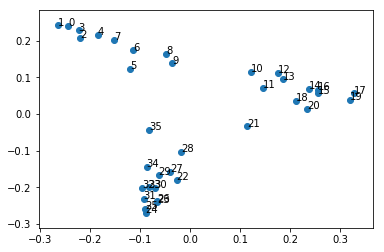

In [9]:
A = read_edge_list('graphs/simple-36-node-graph-edge-list.txt')
embedding = create_embedding(A,2)

plt.scatter(embedding[:,1], embedding[:,0])
for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()

It appears that there are three clusters of nodes. A close examination of the original graph validates that the nodes are grouped together appropriately. K-Means clustering identifies the clusters.


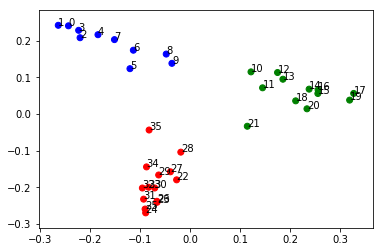

In [10]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(embedding)

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B'][i] for i in kmeans.labels_])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()


## Another Interesting Property of the Laplacian Eigenvectors

Another property of the Laplacian eigenvectors is that the vector corresponding to the second smallest eigenvalue (this will be the vector in column 0 of the embedding) can be used to directly partition the graph into two, approximately equally sized groups, using the smallest number of edge cuts. This is done simply by dividing the nodes into two groups depending on the sign of their corresponding eigenvector element.

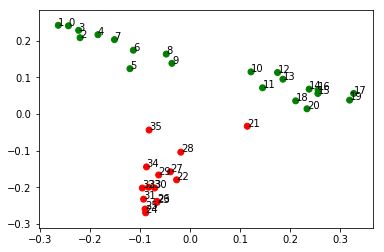

In [11]:
#
#   Create cluster labels (0,1) for graph nodes using the 0-th eigenvector in the embeddings
#
cluster_labels = [int(embedding[:,0][i] > 0.0) for i in range(embedding.shape[0])]

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B'][i] for i in cluster_labels])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()

How does this compare to K-Means clustering with a cluster size of 2.

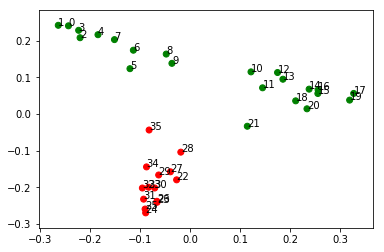

In [12]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding)

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B'][i] for i in kmeans.labels_])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()

The results only differ by one node, node 21. Examining the graph, the difference between the two is one edge cut.


## Some Embedding Intuition

In the tutorial, Tselil Schramm provides some intuition about how to interpret node embeddings using a 6x6 grid. This demonstration is duplicated below.

Begin with a regular, fully connected 6x6 node grid.

![](images/grid-36-node-graph.png)

Create the embedding map as before and plot the 2-dimensional embeddings.


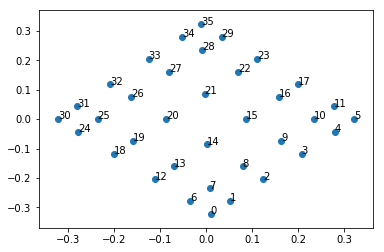

In [13]:
A = read_edge_list('graphs/simple-36-node-graph-grid-edge-list.txt')

embedding = create_embedding(A,2)

plt.scatter(embedding[:,1], embedding[:,0])
for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()


The embeddings accurately represent the edge relationships between nodes. For instance node 0 is furthest away from node 35 representing the greatest number of edge distances between those two nodes (likewise nodes 5 and 30). Notice that the node distances compress somewhat towards the edges. Tselil suggests that this is do to an edge effect similar to a mechanical system where the edges represent springs and the edges are fixed in place.

To demonstrate this further, some edges near the center are removed and the process is repeated.

![](images/grid-36-node-graph-sparse.png)

Some edge connections from the middle have been removed. Create the embeddings as before and display them as a scatter plot.

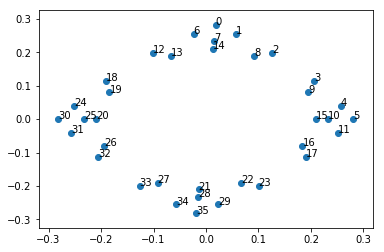

In [14]:
A = read_edge_list('graphs/simple-36-node-graph-grid-sparse-edge-list.txt')

embedding = create_embedding(A,2)

plt.scatter(embedding[:,1], embedding[:,0])
for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()


Now the nodes in the graph corners show much more affinity with their neighbors. A quick check use K-Means demonstrates the clustering.

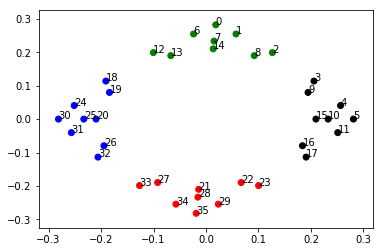

In [15]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(embedding)

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B', 'K'][i] for i in kmeans.labels_])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()